<a href="https://colab.research.google.com/github/agalvezm/ACE2_scRNAseq/blob/master/notebooks_countmatrices/E_MTAB_6701_FCA7196231.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-MTAB-6701_FCA7196231

In [1]:
# define the values for the analysis

# accession id for the data
id = "E-MTAB-6701"
samp_id = ["FCA7196231"]

# If only bam available files, set bam = True, Fill link and filename
bam = False

# If fastq links available but are not ffq links
fastq_ffqlinks = False


if bam:
  # Assign link to python variable
  link_to_bam = ""
  
  # Assigns the link to the bash variable BAM_LINK. To be used by wget
  %env BAM_LINK=$link_to_bam

  # Assign filename to python variable. Used to convert to fastq and remove bam file to fastq after conversion

  bam_filename=""


if not bam:

  # Copy and paste the links from the ACE2 scRNAseq datasets google  spreadsheet
  links_raw = "https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-6701/FCA7196231_S1_L001_R1_001.fastq.gz	https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-6701/FCA7196231_S1_L001_R2_001.fastq.gz"
  links_raw = "ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7196231_R1.fq.gz ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7196231_R2.fq.gz"
  # Convert it to a list where each link is an element
  
  fastqs = links_raw.split()


no_samples = 1

fastqs_per_sample = [1] 

sample_id = samp_id

database_id = [id] * no_samples

tissue = ["placenta"] * no_samples

cell_type = ["None"] * no_samples

condition = ["female, adult, 6 to 12 week gestation"] * no_samples

species = ["human"] * no_samples

technology = ["10xv2"] * no_samples

paper = ["Sungnak et al. Nature medicine (2020)"] * no_samples

figure = ["Fig 1"] * no_samples



# Set string variables for kb functions

species_kb = species[0]

technology_kb = technology[0]



# Imports and installs

In [2]:
# install and import necessary software

# Install kb and scanpy
!pip -q install kb-python 
!pip -q install scanpy

import re
import os

# Setup

import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 59.1MB 75kB/s 
     |████████████████████████████████| 51kB 4.7MB/s 
     |████████████████████████████████| 13.2MB 40.6MB/s 
     |████████████████████████████████| 122kB 43.0MB/s 
     |████████████████████████████████| 10.3MB 15.2MB/s 
     |████████████████████████████████| 112kB 43.1MB/s 
     |████████████████████████████████| 81kB 6.0MB/s 
     |████████████████████████████████| 1.2MB 26.9MB/s 
     |████████████████████████████████| 71kB 6.2MB/s 
     |████████████████████████████████| 51kB 4.9MB/s 


# Downloads: (bam (if bam) and index

In [3]:
if bam:

  # Install bamtofastq from 10x website (only bam files available)
  !wget http://cf.10xgenomics.com/misc/bamtofastq-1.2.0
  !chmod +x bamtofastq-1.2.0
  # Download the bam file
  !wget -- continue ${BAM_LINK}




In [4]:
if bam:
  # Convert to fastq
  !./bamtofastq-1.2.0 --reads-per-fastq=500000000 $bam_filename ./fastqs\

  # Remove original bam file to save space
  !rm $bam_filename


In [5]:
# Store fastq names on a list

if bam:
  # cd into fastqs folder
  %cd /content/fastqs

  #store the name of the folder generated by bamtofastq
  _filename = os.listdir()[0]

  # cd into that folder
  %cd $_filename

  # store fastq names in a list
  fastqs = os.listdir()


  # Remove I1 and R3 reads not relevant for our analysis

  # Initialize list containing elements to remove
  remov_elem = []

  print ("\n\nThis is the complete list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)

  # Search index (I1 or R3) fastqs and remove them from list
  for elem in fastqs:
    if re.search("_R3_", elem) or re.search("_I1_", elem):
      remov_elem = remov_elem +[elem]

  fastqs = [elem for elem in fastqs if elem not in remov_elem] 

  print ("\n\nThis is the filtered list of fastqs:\n -----------")
  for elem in fastqs:
    print (elem)


In [6]:
# Remove fastqs that wont be analyzed to save space
if bam:
  for elem in remov_elem:
    !rm $elem

In [7]:
if bam:
  # sort fastqs alphabetically to get R1 and R2 in order
  fastqs = sorted(fastqs)

In [8]:
# wget fastqs from non ffq links in fastqs folder
if not bam and not fastq_ffqlinks:
  !mkdir fastqs
  %cd fastqs
  for link in fastqs:
    !wget $link --continue

  # update fastqs variable with name of files
  fastqs = sorted(os.listdir())

/content/fastqs
--2021-04-09 16:26:54--  ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7196231_R1.fq.gz
           => ‘FCA7196231_R1.fq.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701 ... done.
==> SIZE FCA7196231_R1.fq.gz ... 6368731380
==> PASV ... done.    ==> RETR FCA7196231_R1.fq.gz ... done.
Length: 6368731380 (5.9G) (unauthoritative)

FCA7196231_R1.fq.gz 100%[===================>]   5.93G  30.4MB/s    in 3m 30s  

2021-04-09 16:30:26 (28.9 MB/s) - ‘FCA7196231_R1.fq.gz’ saved [6368731380]

--2021-04-09 16:30:26--  ftp://ftp.ebi.ac.uk/pub/databases/microarray/data/experiment/MTAB/E-MTAB-6701/FCA7196231_R2.fq.gz
           => ‘FCA7196231_R2.fq.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 1

In [9]:
if bam:
  # Download the corresponding Kallisto index to folder containing fastqs
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam and fastq_ffqlinks:
  %cd /content

  # Download the corresponding Kallisto index to content folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

if not bam and not fastq_ffqlinks:
  %cd /content/fastqs

  # Download the corresponding Kallisto index to fastq folder
  !kb ref -d $species_kb -i index.idx -g t2g.txt -f1 transcriptome.fasta

/content/fastqs
[2021-04-09 17:02:21,499]    INFO Downloading files for human from https://caltech.box.com/shared/static/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz to tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz
100% 2.23G/2.23G [02:00<00:00, 19.8MB/s]
[2021-04-09 17:04:23,778]    INFO Extracting files from tmp/v1nm7lpnqz5syh8dyzdk2zs8bglncfib.gz


In [10]:
# Check to make sure the metadata is in the right order after sorting
print(fastqs)

['FCA7196231_R1.fq.gz', 'FCA7196231_R2.fq.gz']


# Process fastq files (modify kb command according to fastqs list)


In [11]:
fastqs

['FCA7196231_R1.fq.gz', 'FCA7196231_R2.fq.gz']

In [12]:
# Specify the sample number and whether they are paired-ended


if no_samples == 1:

  # Write the kb count command as a string with all fastqs of the list as an input
  cmd = "kb count --h5ad -i index.idx -g t2g.txt -x " + technology_kb + " -o output" + sample_id[0] + " "\
  + "--filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs) + "'"
  
  # Execute it
  !$cmd

# If more than one sample, iterate through fastqs accordingly
else:

  # Initializa counter for fastq files
  j = 0

  # Loop over samples for analysis
  for i in range(no_samples):

    fastqs_to_analyze = fastqs[j:j + fastqs_per_sample[i]]
    # Write the kb count command as a string
    cmd = "kb count --h5ad -i ../index.idx -g ../t2g.txt -x " + technology_kb + " -o output" + sample_id[i] + " \
    --filter bustools -t 2 --overwrite " + "'" +  "' '".join(fastqs_to_analyze) + "'"

    # Execute it
    !$cmd

    # Update j to move to the next set of fastq
    j = j + fastqs_per_sample[i]







[2021-04-09 17:05:06,013]    INFO Using index index.idx to generate BUS file to outputFCA7196231 from
[2021-04-09 17:05:06,013]    INFO         FCA7196231_R1.fq.gz
[2021-04-09 17:05:06,013]    INFO         FCA7196231_R2.fq.gz
[2021-04-09 18:27:44,747]    INFO Sorting BUS file outputFCA7196231/output.bus to outputFCA7196231/tmp/output.s.bus
[2021-04-09 18:32:37,355]    INFO Whitelist not provided
[2021-04-09 18:32:37,355]    INFO Copying pre-packaged 10XV2 whitelist to outputFCA7196231
[2021-04-09 18:32:37,508]    INFO Inspecting BUS file outputFCA7196231/tmp/output.s.bus
[2021-04-09 18:33:05,640]    INFO Correcting BUS records in outputFCA7196231/tmp/output.s.bus to outputFCA7196231/tmp/output.s.c.bus with whitelist outputFCA7196231/10xv2_whitelist.txt
[2021-04-09 18:33:34,199]    INFO Sorting BUS file outputFCA7196231/tmp/output.s.c.bus to outputFCA7196231/output.unfiltered.bus
[2021-04-09 18:35:26,385]    INFO Generating count matrix outputFCA7196231/counts_unfiltered/cells_x_genes f

# Load unfiltered matrix and assign filters to each matrix individually

## Load the unfiltered matrix (check dimensions)

In [15]:
# Define dict to store data
results = {}


In [16]:
# load the unfiltered matrix
for i in range(no_samples):
  results[sample_id[i]] = anndata.read_h5ad("output" + sample_id[i] + "/counts_unfiltered/adata.h5ad")
  results[sample_id[i]].var["gene_id"] = results[sample_id[i]].var.index.values

  t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
  t2g.index = t2g.gene_id
  t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

  results[sample_id[i]].var["gene_name"] = results[sample_id[i]].var.gene_id.map(t2g["gene_name"])
  results[sample_id[i]].var.index = results[sample_id[i]].var["gene_name"]
  print("The unfiltered matrix " + sample_id[i] + " contains {} cells by {} genes".format(len(results[sample_id[i]].obs), len(results[sample_id[i]].var)))

  results[sample_id[i]].obs["cell_counts"] = results[sample_id[i]].X.sum(axis=1)
  results[sample_id[i]].var["gene_counts"] = nd(results[sample_id[i]].X.sum(axis=0))

  results[sample_id[i]].obs["n_genes"] = nd((results[sample_id[i]].X>0).sum(axis=1))
  results[sample_id[i]].var["n_cells"] = nd((results[sample_id[i]].X>0).sum(axis=0))

  mito_genes = results[sample_id[i]].var_names.str.startswith("MT-" or "mt-") 
  results[sample_id[i]].obs["percent_mito"] = results[sample_id[i]][:,mito_genes].X.sum(axis=1)/results[sample_id[i]].X.sum(axis=1)*100

  # Changing the name of the index is necessary to write the file (it won't work with duplicated names)
  results[sample_id[i]].var.index.name = "index"



The unfiltered matrix FCA7196231 contains 242660 cells by 60623 genes


## Assign filters for each matrix individually

In [17]:
# Modify this manually to change sample after having assigned the "expected_num_cells" and "mito_criteria" parameters
samp_n = 0


# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

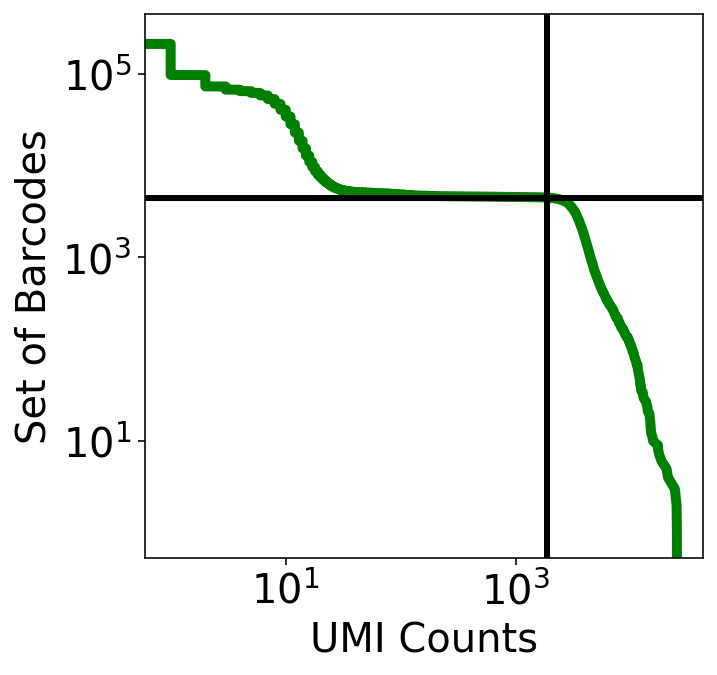

Cells were filtered down to 4500 with at least 1870.0 UMIs


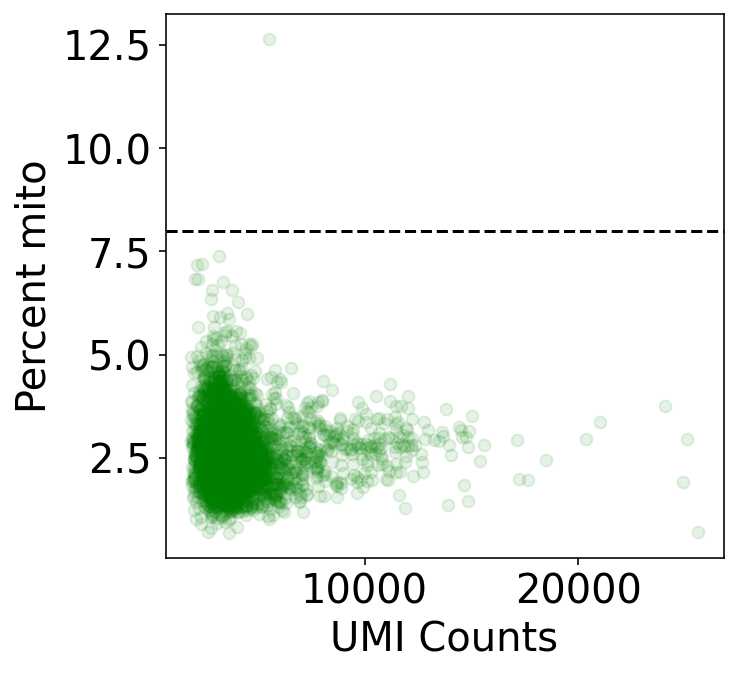

We select 8 % as the mitochondrial content threshold


In [24]:

expected_num_cells = 4500#@param {type:"integer"}
knee = np.sort(nd(results[sample_id[samp_n]].X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

cell_threshold = knee[expected_num_cells]

results["cell_threshold" + sample_id[samp_n]] = knee[expected_num_cells]

print ("Cells were filtered down to " + str(expected_num_cells) + " with at least " + str(cell_threshold) + " UMIs")


mito_criteria = 8#@param {type:"integer"}
results["mito_criteria" + sample_id[samp_n]] = mito_criteria

fig, ax = plt.subplots(figsize=(5,5))


x = nd(results[sample_id[samp_n]].obs["cell_counts"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])
y = nd(results[sample_id[samp_n]].obs["percent_mito"][results[sample_id[samp_n]].obs["cell_counts"] > cell_threshold])

ax.scatter(x, y, color="green", alpha=0.1)

ax.axhline(y=mito_criteria, linestyle="--", color="k")


ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")


plt.show()

print("We select " + str(mito_criteria) + " % as the mitochondrial content threshold")

# Filter matrix

In [25]:
for i in range(no_samples):
  results[sample_id[i]].obs["pass_count_filter"] = results[sample_id[i]].obs["cell_counts"] > results["cell_threshold" + sample_id[i]]
  results[sample_id[i]].obs["pass_mito_filter"] = results[sample_id[i]].obs.percent_mito < results["mito_criteria" + sample_id[i]]
  results[sample_id[i]].var["pass_gene_filter"] = results[sample_id[i]].var["n_cells"] > gene_threshold

  cell_mask = np.logical_and(results[sample_id[i]].obs["pass_count_filter"].values, results[sample_id[i]].obs["pass_mito_filter"].values)
  gene_mask = results[sample_id[i]].var["pass_gene_filter"].values

  print("Current Shape: {:,} cells x {:,} genes".format(results[sample_id[i]].shape[0], results[sample_id[i]].shape[1]))
  print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))
  results["data_" + sample_id[i]] = results[sample_id[i]][cell_mask, gene_mask]

Current Shape: 242,660 cells x 60,623 genes
    New shape: 4,499 cells x 24,832 genes


# Anotate and write the Anndata object

In [26]:
for i in range(no_samples):


  results["data_" + sample_id[i]].uns["database_id"] = database_id[i]

  results["data_" + sample_id[i]].uns["tissue"] = tissue[i]

  results["data_" + sample_id[i]].uns["cell_type"] = cell_type[i]

  results["data_" + sample_id[i]].uns["sample_id"] = sample_id[i]

  results["data_" + sample_id[i]].uns["condition"] = condition[i]

  results["data_" + sample_id[i]].uns["species"] = species[i]

  results["data_" + sample_id[i]].uns["technology"] = technology[i]

  results["data_" + sample_id[i]].uns["paper"] = paper[i]

  results["data_" + sample_id[i]].uns["figure"] = figure[i]


%cd /content

for i in range(no_samples):

  results["data_" + sample_id[i]].write("result" + sample_id[i])

Trying to set attribute `.uns` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


/content


... storing 'gene_name' as categorical
